In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA 


In [3]:
fname = []
for j in range(3):
    fname.append('steinmetz_part%d.npz'%j)

alldat = np.array([])
for j in range(len(fname)):
    alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))

In [13]:
dt = 0.01 # bin duration (ms)
t = np.arange(250)*dt
t -= 0.5 # set timestep 0 to stimulus onset 

In [4]:
def moving_average(signal, n=3) :
    ret = np.cumsum(signal, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [10]:
def single_trial_pca(dat, brain_area, n_components=2, moving_avg_window=3, n_timesteps=250):
    spks = dat['spks'][dat['brain_area'] == brain_area]
    spks = spks[:,:,:n_timesteps]
    
    n_neurons, n_trials, _ = spks.shape
    
    # temporal smoothing
    for i in range(n_neurons):
        for j in range(n_trials):
            spks[i,j,(moving_avg_window-1):] = moving_average(spks[i,j], n=moving_avg_window)
    
    # n_trials*n_timesteps vectors of dimension n_neurons
    X = spks.reshape(n_neurons, n_trials*n_timesteps)
    X = X.T# n_samples = n_trials*n_timesteps x n_features = n_neurons
    
    # substract the mean firing rate for each neuron
    X = X - X.mean(axis=0)
    
    pca = PCA(n_components=n_components)
    
    pca.fit(X)
    proj_X = pca.transform(X)
    proj_X = proj_X.T.reshape(n_trials, n_timesteps, n_components)
    return proj_X, pca.explained_variance_ratio_, pca.components_


In [34]:
session = 25
brain_area = "MOs"
dat = alldat[session]

Explained var for  MOs : [0.03853658]


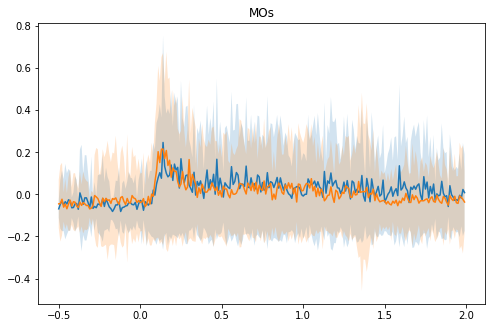

In [37]:
plt.figure(figsize=[8, 30])

# plot the two first principal components
proj_data, explained_var, components = single_trial_pca(dat, brain_area, moving_avg_window=1, n_components=1)
print("Explained var for ", brain_area, ":", explained_var)


#     rew = proj_data[dat['feedback_type'] == 1][:,:,0]
#     pen = proj_data[dat['feedback_type'] == -1][:,:,0]

rew = proj_data[dat['response'] == 1][:,:,0]
pen = proj_data[dat['response'] == -1][:,:,0]

# VISp stim gauche droite sur même session que pour HMM
# stim onset, go cue

plt.subplot(len(brain_areas), 1, i+1)

plt.plot(t, rew.mean(0))
plt.fill_between(t,rew.mean(0)-rew.std(0),rew.mean(0)+rew.std(0),alpha=.2)

plt.plot(t, pen.mean(0))
plt.fill_between(t,pen.mean(0)-pen.std(0),pen.mean(0)+pen.std(0),alpha=.2)

plt.title(brain_area)

plt.show()

